In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    print("Initial Class Distribution:")
    print(data['Spectral Class'].value_counts())
    plot_class_distribution(data['Spectral Class'], title="Initial Class Distribution")
    return data


def plot_class_distribution(class_series, title="Class Distribution"):
    class_series.value_counts().plot(kind='bar', figsize=(8, 6), rot=0, color='skyblue')
    plt.title(title)
    plt.xlabel("Spectral Class")
    plt.ylabel("Frequency")
    plt.show()

In [3]:
def rectify_imbalance(data, target_column='Spectral Class'):
    class_names = data[target_column].unique()
    max_samples = data[target_column].value_counts().max()
    
    balanced_data = pd.DataFrame(columns=data.columns)
    for class_name in class_names:
        class_data = data[data[target_column] == class_name]
        resampled = resample(class_data, replace=True, n_samples=max_samples, random_state=42)
        balanced_data = pd.concat([balanced_data, resampled], ignore_index=True)
    
    print("Balanced Class Distribution:")
    print(balanced_data[target_column].value_counts())
    plot_class_distribution(balanced_data[target_column], title="Balanced Class Distribution")
    return balanced_data

In [4]:
def preprocess_features(data, target_column='Spectral Class'):
    # Separate features and label
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Identify categorical columns (excluding target)
    categorical_cols = X.select_dtypes(include=['object']).columns

    # One-hot encode categorical features
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    X_encoded = encoder.fit_transform(X[categorical_cols])

    # Create DataFrame for encoded features
    encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

    # Combine numerical and encoded categorical features
    numerical_df = X.drop(columns=categorical_cols).reset_index(drop=True)
    processed_X = pd.concat([numerical_df, encoded_df], axis=1)

    return processed_X, y



In [5]:
def split_and_scale(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [6]:
def train_and_evaluate_svm(X_train, y_train, X_test, y_test):
    svm_model = SVC(kernel='rbf', C=10.0, gamma=0.01)
    svm_model.fit(X_train, y_train)
    
    y_pred = svm_model.predict(X_test)
    
    print("SVM Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return svm_model


In [7]:


def train_and_evaluate_kmeans(X_train):
    kmeans_model = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans_model.fit(X_train)

    cluster_labels = kmeans_model.labels_
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    print(f"KMeans Clustering: Average Silhouette Score = {silhouette_avg:.4f}")

    return kmeans_model


In [8]:
def visualize_kmeans(kmeans, X):
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {kmeans.n_clusters}, the average silhouette_score is: {silhouette_avg:.4f}")

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    plt.figure(figsize=(10, 7))

    for i in range(kmeans.n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / kmeans.n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.title("Silhouette Plot for Clusters")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster Label")
    plt.yticks([])
    plt.xticks(np.arange(-0.1, 1.1, 0.2))
    plt.show()

In [9]:


def train_and_evaluate_mlp(X_train, y_train, X_test, y_test):
    mlp_model = MLPClassifier(hidden_layer_sizes=(150, 100, 50), activation='relu',
                              solver='adam', learning_rate_init=0.001, max_iter=2000, random_state=42)
    mlp_model.fit(X_train, y_train)

    y_pred = mlp_model.predict(X_test)
    print("MLP Classification Report:")
    print(classification_report(y_test, y_pred))

    return mlp_model


In [10]:

def train_and_evaluate_cnn(X_train, y_train, X_test, y_test):
    # Reshape for Conv1D: (samples, features, channels)
    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    label_encoder = LabelEncoder()
    y_train_enc = label_encoder.fit_transform(y_train)
    y_test_enc = label_encoder.transform(y_test)

    y_train_cat = to_categorical(y_train_enc)
    y_test_cat = to_categorical(y_test_enc)

    cnn_model = models.Sequential([
        layers.Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(label_encoder.classes_), activation='softmax')
    ])

    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    cnn_model.fit(X_train_cnn, y_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    y_pred_prob = cnn_model.predict(X_test_cnn)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    print("CNN Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    return cnn_model


Initial Class Distribution:
M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: Spectral Class, dtype: int64


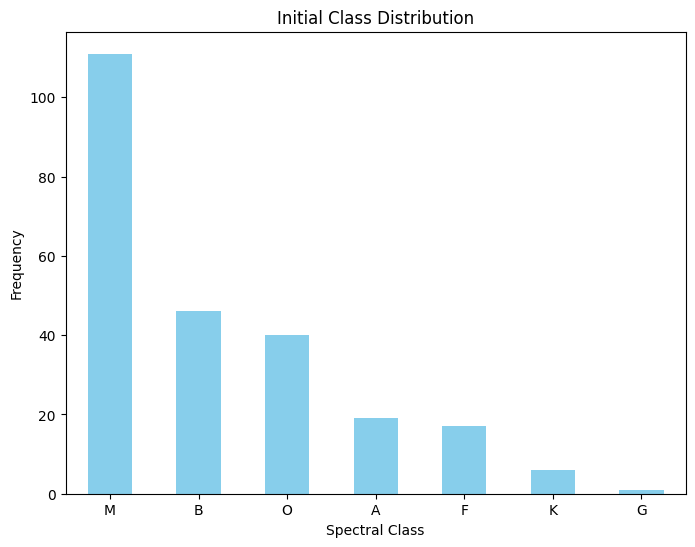

Balanced Class Distribution:
M    111
B    111
A    111
F    111
O    111
K    111
G    111
Name: Spectral Class, dtype: int64


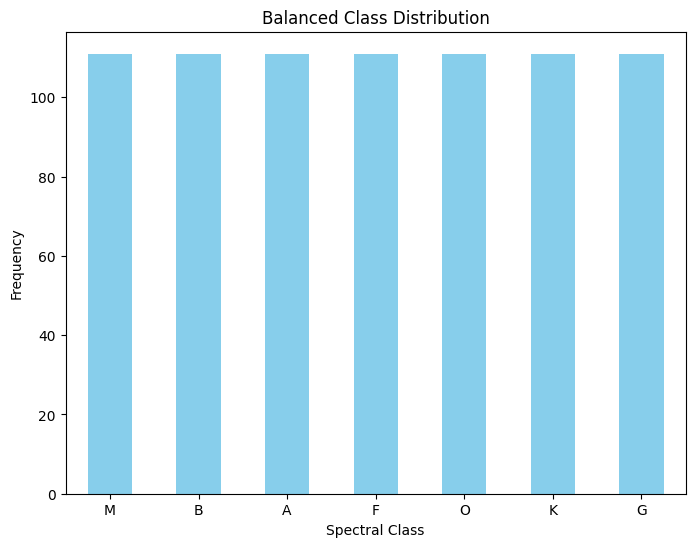

SVM Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        16
           B       1.00      0.94      0.97        18
           F       1.00      1.00      1.00        21
           G       0.92      1.00      0.96        23
           K       0.70      1.00      0.83        26
           M       1.00      0.58      0.73        26
           O       1.00      0.96      0.98        26

    accuracy                           0.92       156
   macro avg       0.95      0.93      0.92       156
weighted avg       0.94      0.92      0.91       156

KMeans Clustering: Average Silhouette Score = -0.0857
For n_clusters = 7, the average silhouette_score is: -0.0857


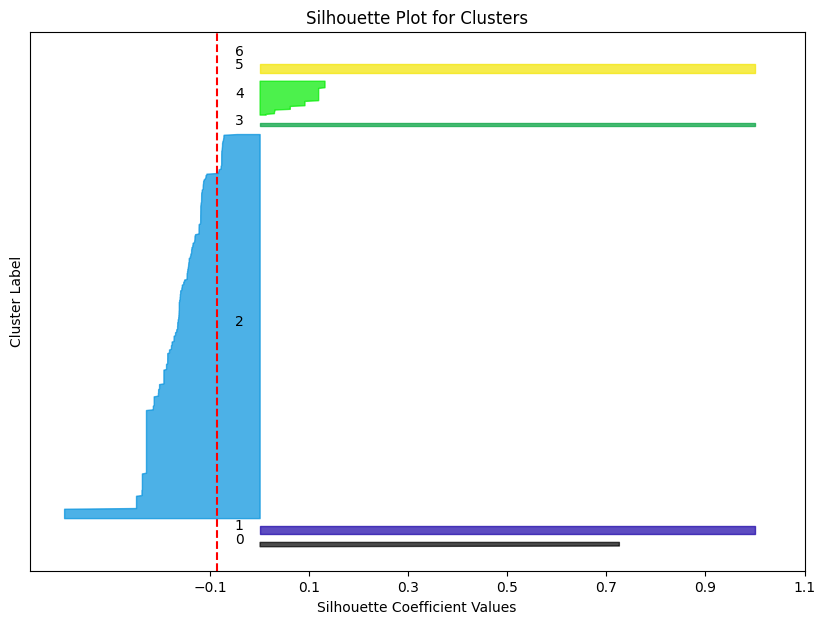

MLP Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        16
           B       1.00      1.00      1.00        18
           F       1.00      1.00      1.00        21
           G       0.92      1.00      0.96        23
           K       0.96      1.00      0.98        26
           M       1.00      0.88      0.94        26
           O       1.00      1.00      1.00        26

    accuracy                           0.98       156
   macro avg       0.98      0.98      0.98       156
weighted avg       0.98      0.98      0.98       156

Epoch 1/10


C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5343 - loss: 1.5601 - val_accuracy: 0.8400 - val_loss: 0.4835
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9076 - loss: 0.3700 - val_accuracy: 0.9520 - val_loss: 0.2133
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9540 - loss: 0.1357 - val_accuracy: 0.9760 - val_loss: 0.0995
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9963 - loss: 0.0340 - val_accuracy: 0.9760 - val_loss: 0.1067
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9892 - loss: 0.0463 - val_accuracy: 0.9680 - val_loss: 0.1719
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9600 - val_loss: 0.1947
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9680 - val_loss: 0.1957
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9680 - val_loss: 0.

In [12]:
def main():
    # Load data
    data = load_data("stars_data.csv")

    # Balance classes
    balanced_data = rectify_imbalance(data)

    # Preprocess features and label
    X, y = preprocess_features(balanced_data)

    # Split and scale data
    X_train, X_test, y_train, y_test = split_and_scale(X, y)

    # Train and evaluate models
    svm_model = train_and_evaluate_svm(X_train, y_train, X_test, y_test)
    kmeans_model = train_and_evaluate_kmeans(X_train)
    visualize_kmeans(kmeans_model, X_train)
    mlp_model = train_and_evaluate_mlp(X_train, y_train, X_test, y_test)
    cnn_model = train_and_evaluate_cnn(X_train, y_train, X_test, y_test)



if __name__ == "__main__":
    main()